# Stock Price Indicator

## Project Overview

Student provides a high-level overview of the project. Background information such as the problem domain, the project origin, and related data sets or input data is provided.


Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.


Here, I build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Inputs contain multiple metrics:
 * opening price (Open)
 * highest price the stock traded at (High)
 * how many stocks were traded (Volume)
Whereas the prediction is made on:
 * closing price adjusted for stock splits and dividends (Adjusted Close)

We want to explore, where possible, S&P500 companies. The list of the listed companies is taken from [here](https://datahub.io/core/s-and-p-500-companies). 
The trading data comes from [Quandl End-of-Day US stock prices](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices) and it is downloaded through their [API](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/usage/quickstart/api) and stored locally. Details are provided into the `Data Exploration` section below.

#### Project Format and Features
The project is developed in the form of a simple script.
<br/>EXTRA: (and any additions/modifications you want to make to the project (e.g. suggesting what trades to make))


## Problem Statement

The aim of the project is to predict stock's adjusted closing prices at 1, 7, 14 and 28 days, by giving stock data a time window of $n$ precedent days. The model should work for highly relevant companies, therefore a few from S&P500 are selected due to data availability.

Data is collected and wrangled to provide training and testing data in the format of features (open, min, max, close, split and dividend) and output vector (the adjusted closing price at the relative time shifts). Data is standardised and a experiments are conducted to test and improve performances.

## Metrics

I used Mean Squared Error to measure performance of the model during training. As a reminder, it is the mean of the squared difference between predicted and true values:

$MSE=\frac{1}{n} \Sigma(Y_i - \hat{Y_i})^2$

which is preferred to the mean absolute error due to its tendency to penalise more bigger errors. By doing so, The aim is to drive to model to avoid big errors rather than producing more equally distributed ones.

## Requirements

Requirements for the python environment can be found in `<repo_folder>/requirements.yml`.

In [20]:
# basics
import os
# data
import json
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor, MultiTaskLassoCV, MultiTaskLasso, RidgeCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# settings
sns.set(style="white")

# data folder
data_folder = os.path.join(os.getcwd(),"..\\data")
costituents_fn = "constituents_csv.csv"
tickers_fn = "tickers.json"
dataset_fn = "dataset.csv"
data_folder

'C:\\dev\\dsnd-spi\\nbooks\\..\\data'

In [2]:
df = pd.read_csv(os.path.join(data_folder,dataset_fn), parse_dates=['Date'], index_col='Unnamed: 0',)
with open(os.path.join(data_folder,tickers_fn)) as f:
    tickers = json.load(f)
df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Ticker
0,2017-12-28,171.00,171.850,170.480,171.08,16480187.0,0.0,1.0,165.971205,166.796208,165.466497,166.048853,16480187.0,AAPL
1,2017-12-27,170.10,170.780,169.710,170.60,21498213.0,0.0,1.0,165.097672,165.757675,164.719142,165.582968,21498213.0,AAPL
2,2017-12-26,170.80,171.470,169.679,170.57,33185536.0,0.0,1.0,165.777087,166.427383,164.689053,165.553851,33185536.0,AAPL
3,2017-12-22,174.68,175.424,174.500,175.01,16349444.0,0.0,1.0,169.542983,170.265103,169.368277,169.863278,16349444.0,AAPL
4,2017-12-21,174.17,176.020,174.100,175.01,20949896.0,0.0,1.0,169.047981,170.843576,168.980040,169.863278,20949896.0,AAPL


## Analysis

### Data Exploration

Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

Here, we explore the data by referring to the CRISP-DM methodology.

### Data Visualization

Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.


In [3]:
# verifying data integrity and basic stats
print(df.isna().sum())
df.describe()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Dividend      0
Split         0
Adj_Open      0
Adj_High      0
Adj_Low       0
Adj_Close     0
Adj_Volume    0
Ticker        0
dtype: int64


,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04
mean,95.491669,96.171887,94.818211,95.521521,1.226938e+07,0.009154,1.000316,81.437157,82.014518,80.866317,81.463475,1.286934e+07
std,59.333158,59.766797,58.916946,59.355129,1.500732e+07,0.085350,0.038147,43.340742,43.637986,43.056648,43.358424,1.609089e+07
min,17.350000,17.400000,17.250000,17.360000,3.053580e+05,0.000000,1.000000,16.190719,16.250819,16.102600,16.186081,3.053580e+05
25%,55.372500,55.870000,54.980000,55.395000,3.847515e+06,0.000000,1.000000,47.642711,48.065195,47.263770,47.650090,4.104089e+06
50%,87.845000,88.400000,87.170000,87.840000,7.197633e+06,0.000000,1.000000,76.139854,76.664216,75.628460,76.147526,7.490536e+06
75%,118.560000,119.290000,117.707500,118.580000,1.526566e+07,0.000000,1.000000,105.912443,106.673449,105.180398,105.948241,1.574847e+07
max,649.900000,651.260000,644.470000,647.350000,6.166205e+08,3.290000,7.000000,286.481931,286.913264,284.785353,285.542583,6.166205e+08


In [4]:
# check whether the period is shared across companies, bringin together first date, last date and the difference between the two
m = pd.merge(
    pd.merge(
        df.groupby('Ticker')['Date'].min(),
        df.groupby('Ticker')['Date'].max(),
        left_index=True,
        right_index=True),
    df.groupby('Ticker')['Date'].max()-df.groupby('Ticker')['Date'].min(),
    left_index=True,
    right_index=True
)
m.columns = ['start date','end date', 'difference']
m

,start date,end date,difference
Ticker,,,
AAPL,2013-09-03,2017-12-28,1577 days
AXP,2013-09-03,2017-12-28,1577 days
BA,2013-09-03,2017-12-28,1577 days
CAT,2013-09-03,2017-12-28,1577 days
CSCO,2013-09-03,2017-12-28,1577 days
CVX,2013-09-03,2017-12-28,1577 days
DIS,2013-09-03,2017-12-28,1577 days
GE,2013-09-03,2017-12-28,1577 days
GS,2013-09-03,2017-12-28,1577 days


C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


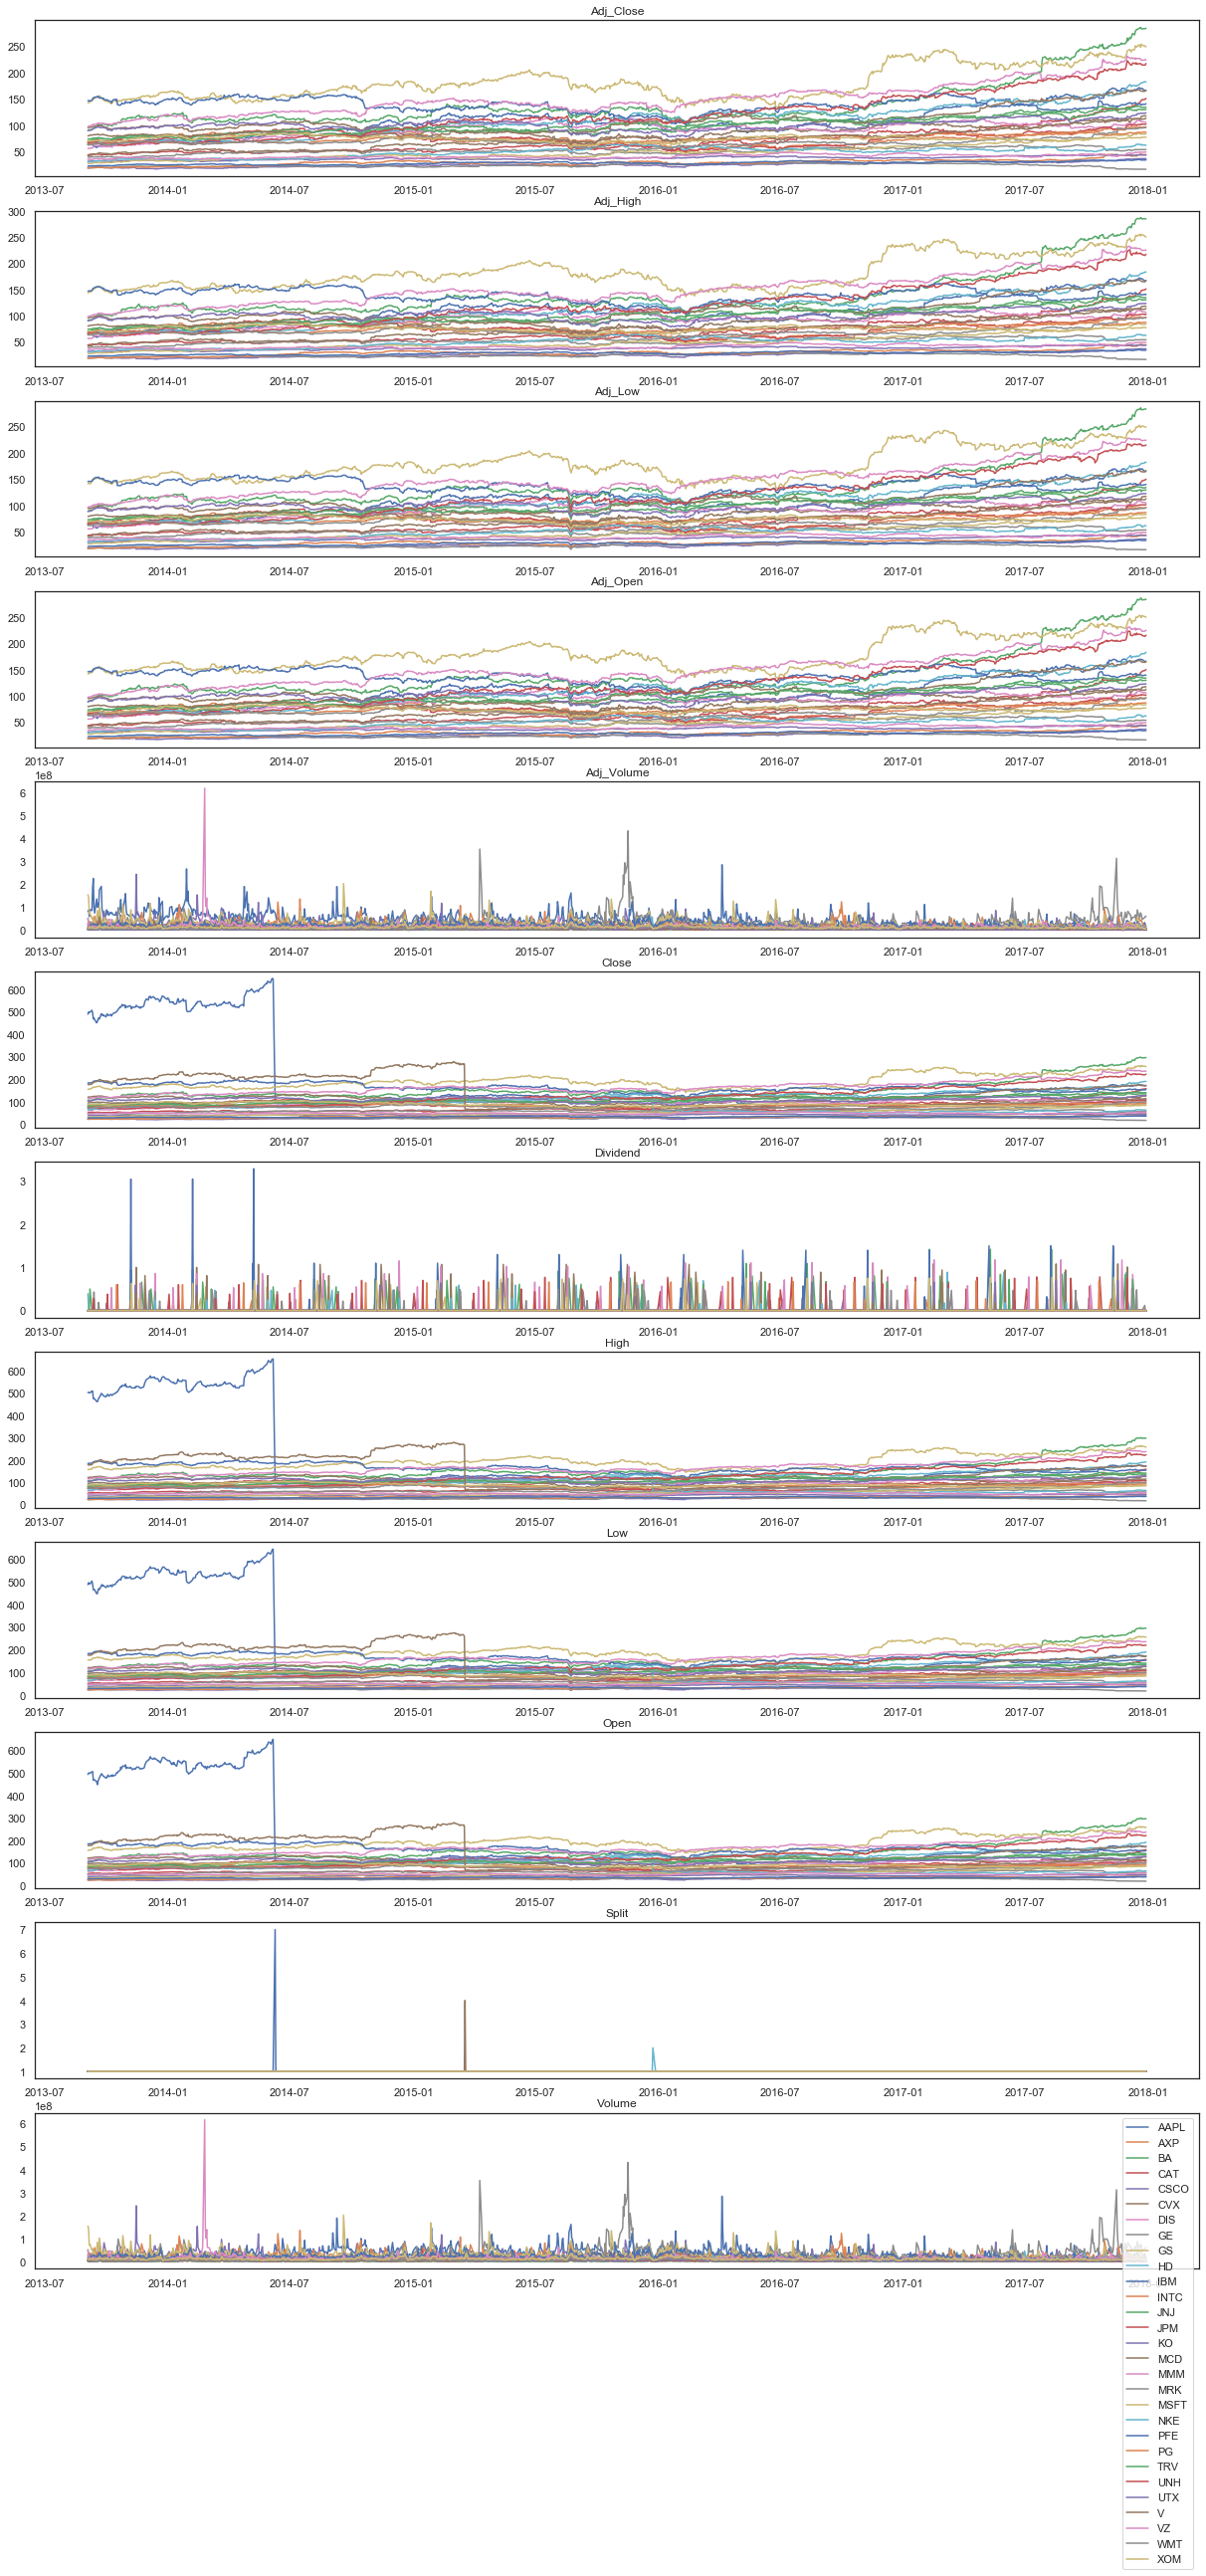

In [5]:
# plot timeseries by company
cols_to_plot = list(set(df.columns) - set(['Ticker', 'Date']))
cols_to_plot.sort()
gs = df.groupby('Ticker')

fig,axs = plt.subplots(nrows=len(cols_to_plot),ncols=1,figsize=(17,32))
plt.tight_layout()

for col,ax in zip(cols_to_plot,axs):
    for n,g in gs:
        x = g['Date']
        y = g[col]
        ax.plot(x,y,label=n)
        ax.set_title(col)
    # print legend once
    if col == cols_to_plot[-1]:
        ax.legend()

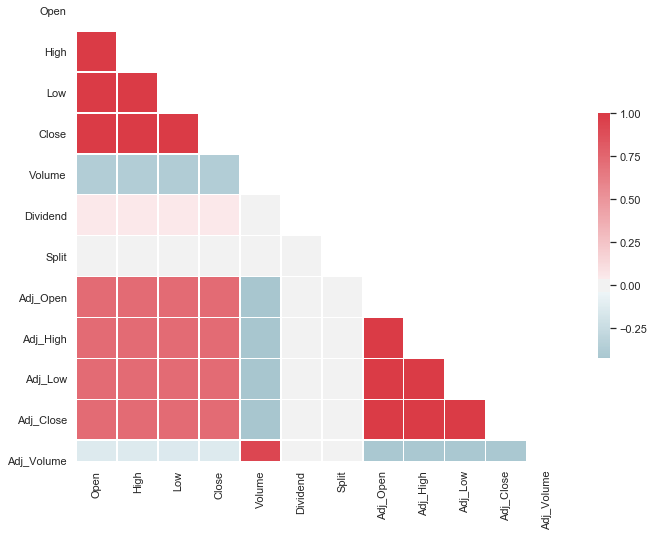

In [6]:
# plot correlation matrix
df_gen = df.drop(columns=['Ticker','Date'])
corr = df_gen.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,vmax=1., center=0,cmap=cmap, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Methodology

## Data Preprocessing

Preprocessing steps consist of a series of steps, applied per each ticker series in the dataset:
* **feature engineering**: adding technical indicators to enhance the input data.
* **windowing**: as the data comes in the form of a time series, it is required to be stored as an time-related array of features.
* **closing price projection**: we extract the adjusted closing price for each window, at 1, 7, 14 and 28 days.
* **scaling (standardization)**: whereas stock prices and dividends are of similar nature (currency), volume and split occur at a different unit.<br/>*NOTE*: the scaling is applied at the whole dataset, regardless of the ticker.
* **train-test split**: train and test datasets are created in a ratio of 70-30, where the 30 represent the last 30% of the series to avoid [look-ahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp)

by using skleanr's `TimeSeriesSplit`

### Techincal Indicators


In [7]:
def rename_cols(df, prefix, sep='_'):
    cols = df.columns
    new_cols = [prefix+sep+c for c in cols]
    df.columns=new_cols
    return df

def calculate_RSI(df, window=5):
    # RSI by wilder
    # gett al differences and separate positive and negative
    df_diff = df.diff()
    gain, loss = df_diff.copy(), df_diff.copy()
    gain[gain < 0] = 0 # set neg to zero
    loss[loss > 0] = 0 # set pos to zero
    # calc mean gains and losses
    av_gain = gain.ewm(com=window,adjust=False).mean()
    av_loss = loss.ewm(com=window, adjust=False).mean().abs()
    # RSI
    rsi = 100 - 100 / (1 + av_gain / av_loss)
    return rename_cols(rsi,'RSI')

def calculate_SMA(df, window=5):
    # Simple Moving Average
    SMA = df.rolling(window=window, min_periods=window, center=False).mean()
    return rename_cols(SMA,'SMA')

def calculate_BB(df, window=5):
    # Bollinger Bands @ mean-/+2*st_dev
    # calc st_dev and mean
    STD = df.rolling(window=window,min_periods=window, center=False).std()
    SMA = calculate_SMA(df)
    upper_band = pd.DataFrame(SMA.values + (2 * STD.values),columns=df.columns)
    lower_band = pd.DataFrame(SMA.values - (2 * STD.values),columns=df.columns)
    return rename_cols(upper_band,'BB_up'), rename_cols(lower_band,'BB_low')

### Feature engineering and windowing

In [8]:
def preprocess_data(df, window=5, to_drop=['Date','Ticker'], y_label='Adj_Close', grouper='Ticker'):
    """ Feature engineer the data by adding returns and other above mentioned Tis, 
        trim data by a given time window and calculate the associated adjusted closing price at 1,7,14 and 28 days.
    
    Parameters
    ----------
    df : DataFrame
        data
    
    window : int
        window size (days)
    
    to_drop : array-like
        [optional] column names to drop, default=['Date','Ticker']
    
    y_label : str
        [optional] label to predict, default='Adj_Close'
    
    grouper : string
        [optional] name of the column which represents the company - typically, the ticker, default='Ticker'
    
    Returns
    -------
    X : array
        input tensor for the specificed window. If data is of shape (n,m), X will have shape (n,w,m)
        NOTE: m is the numer of features, but the ones to drop
    
    y : array
        output vector for the adjusted closing price at 1,7,14 and 28 days, of shape=(n,1,4)
    """
    # Technical Indicators
    TI_window = window
    prices = ['Open','High','Low','Close','Adj_Open','Adj_High','Adj_Low','Adj_Close']
    eod = ['Open','Close','Adj_Open','Adj_Close']
    

    # WINDOWING
    groups = df.groupby(grouper)
    X = []
    y = []
    tickers = []
    dates = []
    for n,g in groups:
        # NOTE: we could add a company-related information (e.g. volatility index)
        g = g.reset_index(drop=True)
        # save columns not releevant for TI
        backup_ = g[to_drop+['Dividend','Split']].copy()
        # take the rest
        df_g = g.copy().drop(columns=to_drop+['Dividend','Split'])
        # calc daily returns
        df_g['Return']  = (df_g['Close']-df_g['Open'])/df_g['Open']
        df_g['Adj_Return']  = (df_g['Adj_Close']-df_g['Adj_Open'])/df_g['Adj_Open']
        # TI
        df_g = pd.concat((df_g, calculate_RSI(df_g[prices],window=TI_window)), axis=1, sort=False)
        df_g = pd.concat((df_g, calculate_SMA(df_g[prices],window=TI_window)), axis=1, sort=False)
        df_g = pd.concat((df_g, calculate_BB(df_g[eod],window=TI_window)[0]), axis=1, sort=False)
        df_g = pd.concat((df_g, calculate_BB(df_g[eod],window=TI_window)[1]), axis=1, sort=False)
        # re-join date, ticker, dividend and split
        df_g = pd.concat((backup_,df_g), axis=1, sort=False)
        # define the start to avoid nans in the dataset
        start = (window-1)+(TI_window-1)
        for i in range(start, len(df_g)-28):
            # drop and transform X
            data = df_g[i-(window-1):i+1].drop(columns=to_drop,inplace=False).copy()
            data = data.reset_index(drop=True)
            # transform y - remember to increase dimensionality of the array
            pred = np.expand_dims(np.array([df_g.loc[i+1,y_label],df_g.loc[i+7,y_label],df_g.loc[i+14,y_label],df_g.loc[i+28,y_label]]),0)
            # done-
            X.append(data.values)
            y.append(pred)
            tickers.append(n)
            dates.append(g.loc[i]['Date'])
    # we trim the initial part as it contains nan from the TIs
    X = np.array(X)[window:,...]
    y = np.array(y)[window:,...]
    tickers = np.array(tickers)[window:,...]
    dates = np.array(dates)[window:,...]
    return X.reshape(X.shape[0],-1), y.reshape(y.shape[0],-1), tickers, dates


In [9]:
X,y,tickers,dates = preprocess_data(df,8)
print(df.shape, X.shape, y.shape, tickers.shape, dates.shape)
print("NaN values:",np.count_nonzero(pd.isnull(X)))

(31610, 14) (30384, 304) (30384, 4) (30384,) (30384,)
NaN values: 0


### Scaling

Here we scale the whole dataset through a standard scaling.

In [10]:
ss = StandardScaler()
X_ss = ss.fit_transform(X)

### Train-Test  and Validation split

The split is performed to avoid look-ahead bias. Therefore, we split the data into two dataset:
* Train-Test will be used to train the model by cross-validation.
* Validation set, which is a part of the data the model has never seen. Time-wise, this is at the end of our dataset.

In [12]:
def gen_train_test_and_valid_data(ticker, X, y, ts_split=0.7):
    """
    """
    X_stock = X[(tickers==ticker),...]
    y_stock = y[(tickers==ticker),...]
    d_stock = dates[tickers==ticker]
    
    idx = int(X_stock.shape[0]*ts_split)
    X_train, X_valid = X_stock[:idx,...],X_stock[idx:,...]
    y_train, y_valid = y_stock[:idx,...],y_stock[idx:,...]
    return X_train, X_valid, y_train, y_valid, d_stock

X_train, X_valid, y_train, y_valid, t_dates = gen_train_test_and_valid_data('AAPL', X_ss, y)

In [13]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((728, 304), (312, 304), (728, 4), (312, 4))


## Implementation

A standard process is developed in order to process a fittable object through a series of steps; this can be a model, gridsearch or pipeline.
* The whole dataset is split between train and validation sets, by company.
* The object is fit on all the training data
* A final validation is conducted against the whole validation set. Best nad worst predictable companies are registered.

We run this process three times:
 1. **Benchmark Model**: a decision tree regressor with sk-learn standard parameters is used as a benchmark model.
 2. **Model Testing**: a series of selected models (see below): models are fit and evaluated
 3. **Refinements**: pipelines to improve selected models through grid-search are used to perform cross-validation over the time series.


The objective output is a 4-class vector which represent the closing stock price at 1,7,14 and 28 days.

Eventually, 4 different models which handle 1-d output might be trained for the scope. Here, GridSearch is not performed yet, as it might lead to a data leak due to the previous scaling. Mean squared error is used to evaluate the model performances on the training and test sets. <br/>
The first run produces a model whose performances show a clear overfitting (MSE on training is about 6 times lower than the MSE on the test set).


In [14]:
def fit_on_all_data(mdl, X, y, train_percentage=0.7):
    """ train a fit-able object on the whole dataset
    
    Parameters
    ----------
    mdl : model, pipeline or GridSearchCV
        object to train
    
    train_percentage : float
        [optional] split training and validation set (default=0.7)
    
    Returns
    -------
    object
        trained object
    """
    tickers = df['Ticker'].unique()
    X_train, X_valid, y_train, y_valid, t_dates = gen_train_test_and_valid_data(tickers[0], X, y,train_percentage)
    xt = np.array(X_train)
    yt = np.array(y_train)
    xv = np.array(X_valid)
    yv = np.array(y_valid)
    for t in tickers[1:]:
        X_train, X_valid, y_train, y_valid, t_dates = gen_train_test_and_valid_data(t, X, y,0.7)
        xt = np.concatenate((xt,X_train))
        yt = np.concatenate((yt,y_train))
    mdl.fit(xt, yt)
    return mdl

In [15]:
def validate_model(model, X, y, ticker, plot=True, print_output=True, ts_split=0.7):
    """
    """
    X_train, X_valid, y_train, y_valid, dates = gen_train_test_and_valid_data(ticker, X, y, ts_split=ts_split)
    # predictions
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    # performances - scale inverse
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    r2_train   = r2_score(y_train, y_pred_train)
    r2_valid   = r2_score(y_valid, y_pred_valid)
    if print_output:
        print('{:=^50}'.format("VALIDATION FOR "+ticker))
        print("TRAIN RMSE:    ",rmse_train)
        print("VALID RMSE:    ",rmse_valid)
        print('-')
        print("TRAIN R2 Error:",r2_train)
        print("VALID R2 Error:",r2_valid)
    
    if plot:
        fig,axs = plt.subplots(2,2,figsize=(16,8))
        days=[1,7,14,28]
        for i in range(len(axs)):
            for j in range(len(axs[i])):
                idx = j + i*(len(axs[i]))
                y_1=y_pred_valid.T[idx]
                y_2=y_valid.T[idx]
                x=np.arange(y_1.shape[0])
                axs[i][j].plot(x,y_1,label='pred')
                axs[i][j].plot(x,y_2,label='truth')
                axs[i][j].set_title('Adjusted Close Price @ {} days'.format(days[idx]))
                axs[i][j].legend()
        plt.show();
    return rmse_train, rmse_valid,  r2_train, r2_valid

In [16]:
def validate_on_all_data(model, X, y, ts_split=0.7,  plot_singles=False, plot_overall=True):
    results = []
    tickers = df['Ticker'].unique()
    for t in tickers:
        r1,r2,r3,r4 = validate_model(model, X, y, t, plot=plot_singles, print_output=False)
        results.append([r1,r2,r3,r4])
    ks = np.array(tickers)
    vs = np.array(results).T
    # create a df for results and plot from most to least predictable ticker
    res = pd.DataFrame({'Ticker':ks,'RMSE_train':vs[0],'RMSE_valid':vs[1],'R2_train':vs[2],'R2_valid':vs[3]}).sort_values(by='RMSE_valid').reset_index(drop=True)
    if plot_overall:
        ax = res.plot(x='Ticker',y=['RMSE_train','RMSE_valid'],title='RMSE Validation for all Tickers')
        ax.set_xticks(res.index)
        ax.set_xticklabels(res['Ticker'],rotation=90)
        plt.grid()
        plt.show();
    return res

### Benchmark Model

Scikit-leanr's DecisionTreeRegressor with default parameters is used as the benchmark model for this project.

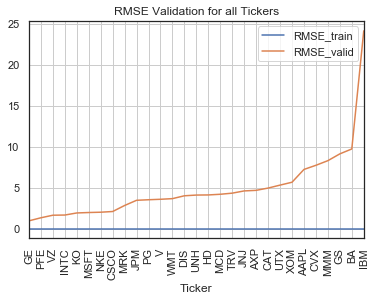

In [17]:
# benchmark model
bm_mdl = DecisionTreeRegressor(random_state=0)
bm_mdl = fit_on_all_data(bm_mdl, X_ss, y) #fit
bm_res = validate_on_all_data(bm_mdl, X_ss, y)

In [18]:
bm_res

,Ticker,RMSE_train,RMSE_valid,R2_train,R2_valid
0,GE,0.0,0.939871,1.0,-0.454757
1,PFE,0.0,1.313880,1.0,-1.086594
2,VZ,0.0,1.626120,1.0,-0.323203
3,INTC,0.0,1.647747,1.0,0.837976
4,KO,0.0,1.901515,1.0,-0.168269
5,MSFT,0.0,1.955191,1.0,0.788477
6,NKE,0.0,1.992813,1.0,0.668989
7,CSCO,0.0,2.077986,1.0,-0.784506
8,MRK,0.0,2.813308,1.0,0.567459
9,JPM,0.0,3.446892,1.0,-0.754865


================VALIDATION FOR GE=================
TRAIN RMSE:     0.0
VALID RMSE:     0.9398714941655515
-
TRAIN R2 Error: 1.0
VALID R2 Error: -0.45475650321417466


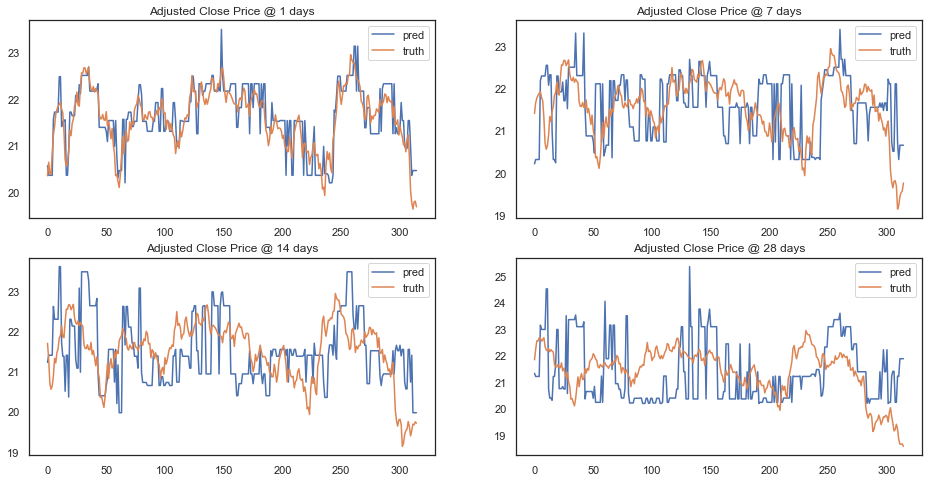

================VALIDATION FOR DIS================
TRAIN RMSE:     0.0
VALID RMSE:     3.9983556254210977
-
TRAIN R2 Error: 1.0
VALID R2 Error: 0.7454443320819255


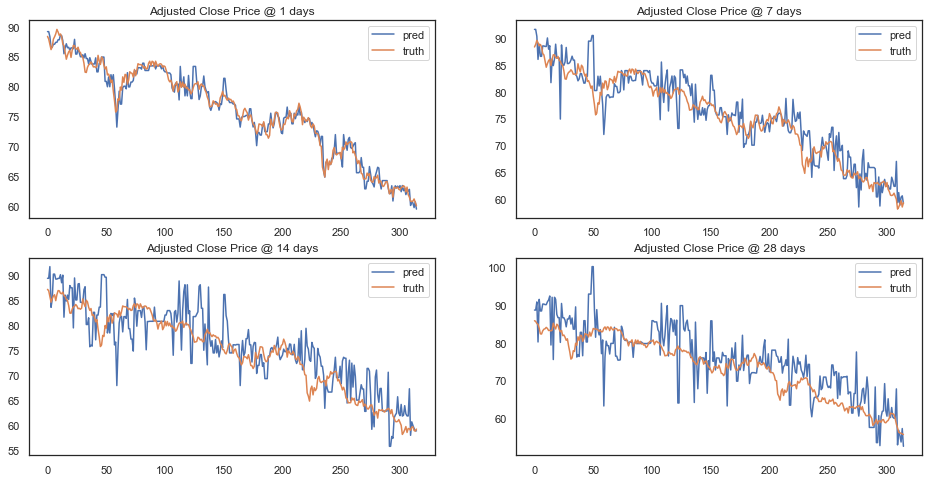

================VALIDATION FOR IBM================
TRAIN RMSE:     0.0
VALID RMSE:     24.124613316686506
-
TRAIN R2 Error: 1.0
VALID R2 Error: -9.674791611311342


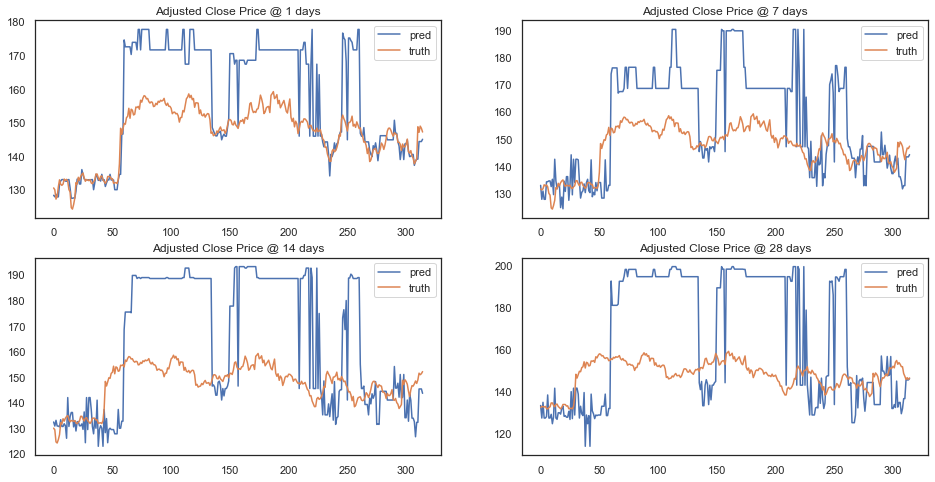

(0.0, 24.124613316686506, 1.0, -9.674791611311342)

In [21]:
validate_model(bm_mdl, X_ss, y, 'GE')
validate_model(bm_mdl, X_ss, y, 'DIS')
validate_model(bm_mdl, X_ss, y, 'IBM')

### Models testing

Here we test a series of models and we try to improve them by applying grid search.

* RandomForestRegressor
* Stochastic Gradient Descent
* Support Vector Regressor
* Lasso 
* Ridge



In [399]:
models = {'RF'   :RandomForestRegressor(n_estimators=10),
          'SGD'  :MultiOutputRegressor(SGDRegressor()),
          'SVR'  :MultiOutputRegressor(SVR(gamma='scale')),
          'Lasso':MultiTaskLassoCV(cv=5),
          'Ridge':RidgeCV(cv=5)
         }

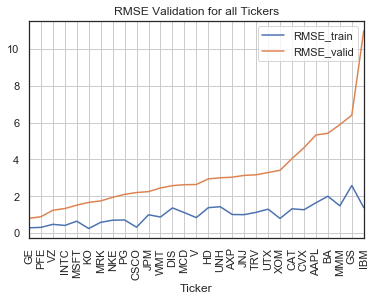

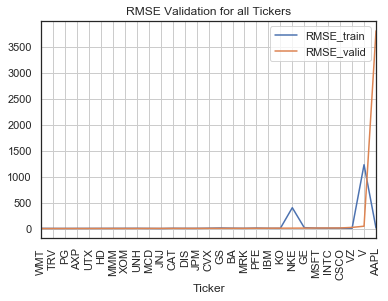

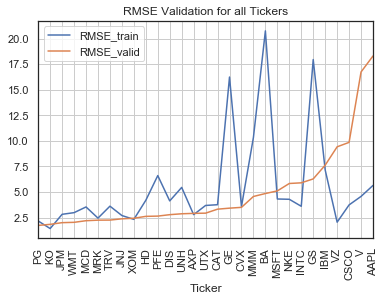

C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1803: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64631.02453325968, tolerance: 16734.183814891057
  check_random_state(self.random_state), random)


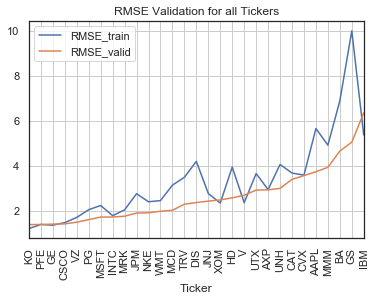

C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses mult

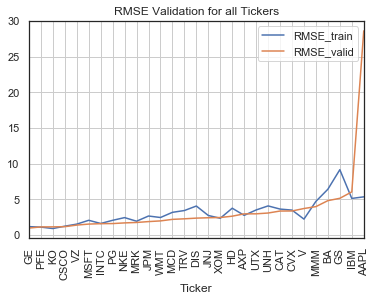

In [400]:
results = {}
for name,mdl in models.items():
    mdl = fit_on_all_data(mdl, X_ss,y)
    rr = validate_on_all_data(mdl, X_ss, y)
    results[name]=rr

In [417]:
# bests,avgs,worsts=[],[],[]
df_rs = pd.DataFrame(results['RF'])
cols  = ['Ticker','RMSE_train_RF','RMSE_valid_RF','R2_train_RF','R2_valid_RF']
for k,v in results.items():
    if not k=='RF':
        c = ['RMSE_train_'+k,'RMSE_valid_'+k,'R2_train_'+k,'R2_valid_'+k]
        cols+=c
        tmp=pd.DataFrame(v)
        tmp.columns=['Ticker']+c
        df_rs = pd.merge(df_rs, tmp, on='Ticker')
df_rs.columns = cols
df_rs.head()

,Ticker,RMSE_train_RF,RMSE_valid_RF,R2_train_RF,R2_valid_RF,RMSE_train_SGD,RMSE_valid_SGD,R2_train_SGD,R2_valid_SGD,RMSE_train_SVR,...,R2_train_SVR,R2_valid_SVR,RMSE_train_Lasso,RMSE_valid_Lasso,R2_train_Lasso,R2_valid_Lasso,RMSE_train_Ridge,RMSE_valid_Ridge,R2_train_Ridge,R2_valid_Ridge
0,GE,0.289919,0.802033,0.986921,-0.080841,29.097698,20.139643,-128.249774,-768.496704,16.239260,...,-37.767736,-21.394799,1.368410,1.415377,0.711794,-2.370019,1.163687,0.963598,0.787068,-0.477598
1,PFE,0.311877,0.890294,0.969730,0.038854,20.878648,17.881947,-134.177393,-395.136855,6.606216,...,-12.457428,-7.665084,1.399961,1.400253,0.390187,-1.381807,1.096682,1.122971,0.624983,-0.522038
2,VZ,0.476855,1.241692,0.975719,0.226021,16.641466,33.918939,-28.959778,-579.570288,2.051913,...,0.548721,-46.112060,1.714482,1.500831,0.687086,-0.134674,1.515958,1.380802,0.755660,0.053555
3,INTC,0.417340,1.334683,0.984059,0.893517,18.275574,22.385433,-27.718669,-28.012176,3.605721,...,-0.085832,-1.006241,1.790876,1.731657,0.701982,0.821093,1.605749,1.578353,0.757016,0.850222
4,MSFT,0.648251,1.517920,0.996458,0.872842,19.901835,21.842127,-2.284966,-25.608199,4.319354,...,0.846703,-0.470617,2.242117,1.728360,0.957323,0.834949,2.054051,1.522417,0.964206,0.872230


In [490]:
df_rs.iloc[:,:7]

,Ticker,RMSE_train_RF,RMSE_valid_RF,R2_train_RF,R2_valid_RF,RMSE_train_SGD,RMSE_valid_SGD
0,GE,0.289919,0.802033,0.986921,-0.080841,29.097698,20.139643
1,PFE,0.311877,0.890294,0.969730,0.038854,20.878648,17.881947
2,VZ,0.476855,1.241692,0.975719,0.226021,16.641466,33.918939
3,INTC,0.417340,1.334683,0.984059,0.893517,18.275574,22.385433
4,MSFT,0.648251,1.517920,0.996458,0.872842,19.901835,21.842127
5,KO,0.248958,1.670166,0.990425,0.097897,16.307069,19.074644
6,MRK,0.586314,1.748191,0.986352,0.832470,16.265173,16.158193
7,NKE,0.702744,1.944690,0.976167,0.684543,412.382397,19.594390
8,PG,0.713240,2.105242,0.987747,0.584425,14.022727,12.807131
9,CSCO,0.321984,2.204890,0.988218,-1.017451,18.710024,22.913129


In [493]:
pd.merge(df_rs.iloc[:,:1],df_rs.iloc[:,7:13],left_index=True, right_index=True)

,Ticker,R2_train_SGD,R2_valid_SGD,RMSE_train_SVR,RMSE_valid_SVR,R2_train_SVR,R2_valid_SVR
0,GE,-128.249774,-768.496704,16.239260,3.422879,-37.767736,-21.394799
1,PFE,-134.177393,-395.136855,6.606216,2.646302,-12.457428,-7.665084
2,VZ,-28.959778,-579.570288,2.051913,9.418686,0.548721,-46.112060
3,INTC,-27.718669,-28.012176,3.605721,5.898453,-0.085832,-1.006241
4,MSFT,-2.284966,-25.608199,4.319354,5.109776,0.846703,-0.470617
5,KO,-39.231050,-115.364163,1.430590,1.840017,0.687213,-0.094655
6,MRK,-9.514151,-13.583071,2.449079,2.249734,0.761804,0.721762
7,NKE,-8231.629426,-28.170341,4.289961,5.834492,0.101956,-1.706765
8,PG,-3.708646,-12.538335,2.169077,1.736501,0.886610,0.718926
9,CSCO,-38.028247,-215.544936,3.740059,9.853425,-0.545208,-36.178052


In [494]:
pd.merge(df_rs.iloc[:,:1],df_rs.iloc[:,13:],left_index=True, right_index=True)

,Ticker,RMSE_train_Lasso,RMSE_valid_Lasso,R2_train_Lasso,R2_valid_Lasso,RMSE_train_Ridge,RMSE_valid_Ridge,R2_train_Ridge,R2_valid_Ridge
0,GE,1.368410,1.415377,0.711794,-2.370019,1.163687,0.963598,0.787068,-0.477598
1,PFE,1.399961,1.400253,0.390187,-1.381807,1.096682,1.122971,0.624983,-0.522038
2,VZ,1.714482,1.500831,0.687086,-0.134674,1.515958,1.380802,0.755660,0.053555
3,INTC,1.790876,1.731657,0.701982,0.821093,1.605749,1.578353,0.757016,0.850222
4,MSFT,2.242117,1.728360,0.957323,0.834949,2.054051,1.522417,0.964206,0.872230
5,KO,1.219757,1.392964,0.770268,0.371315,0.895905,1.132836,0.875354,0.584172
6,MRK,2.048008,1.767645,0.833539,0.829697,1.924847,1.746910,0.852969,0.834468
7,NKE,2.408349,1.919028,0.721332,0.686035,2.429223,1.686951,0.716796,0.757462
8,PG,2.056726,1.616347,0.898006,0.755139,2.050876,1.593699,0.898520,0.760577
9,CSCO,1.484792,1.426805,0.747446,0.135378,1.226155,1.157866,0.826928,0.411492


In [476]:
#ok, but here we want to look at RMSE only
to_drop = df_rs.columns[df_rs.columns.str.contains('R2')]
df_results = df_rs.drop(columns=to_drop)
# df_results['RMSE_train_mean']=df_results.loc[:,df_results.columns.str.contains('train')].mean(axis=1)
# df_results['RMSE_valid_mean']=df_results.loc[:,df_results.columns.str.contains('valid')].mean(axis=1)
# order mean performance
summary = pd.DataFrame(df_results.sum(axis=0)[1:])
tr_summary = pd.DataFrame(summary[summary.index.str.contains('train')])
tr_summary.columns=['train']
tr_summary.index=pd.Series(tr_summary.index).apply(lambda x:x.replace('train_',''))
vd_summary = pd.DataFrame(summary[summary.index.str.contains('valid')])
vd_summary.columns=['valid']
vd_summary.index=pd.Series(vd_summary.index).apply(lambda x:x.replace('valid_',''))
score_summary = pd.merge(tr_summary,vd_summary,left_index=True,right_index=True)
score_summary = score_summary.sort_values('valid')
score_summary

,train,valid
RMSE_Lasso,96.0046,76.2808
RMSE_RF,29.6626,92.7141
RMSE_Ridge,90.905,99.9992
RMSE_SVR,158.898,140.63
RMSE_SGD,2115.57,4317.6


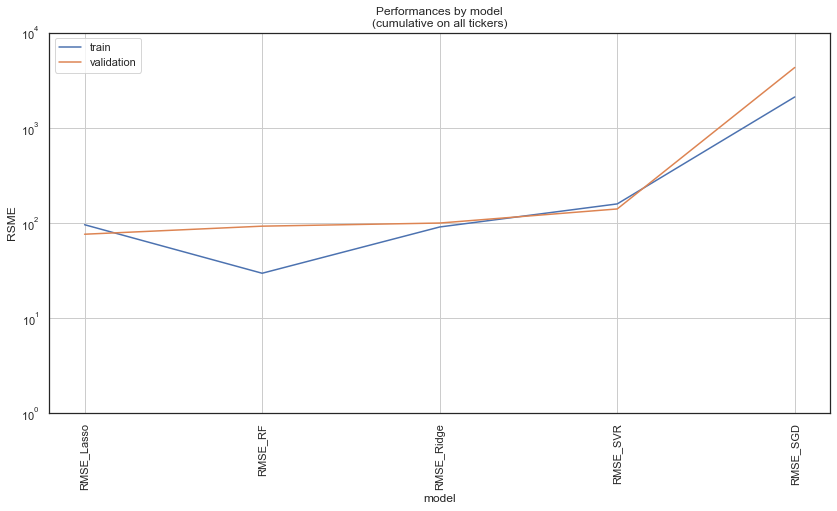

In [481]:
names = score_summary.index.values
tr_scores = score_summary['train'].values
vd_scores = score_summary['valid'].values
plt.figure(figsize=(14,7))
plt.plot(names,tr_scores,label='train')
plt.plot(names,vd_scores,label='validation')
plt.yscale('log')
plt.xlabel('model')
plt.ylabel('RSME')
plt.ylim((1,1e4))
plt.title('Performances by model\n(cumulative on all tickers)')
plt.legend()
plt.grid()
plt.xticks(rotation=90);
# df_results.sort_values(by='RMSE_mean').reset_index(drop=True)

## Refinement

To avoid overfitting, I repeat what above, but by building a pipeline object which comprehends a scaler to then perform a grid search to tune the hyper-parameters. Therefore, the windowing is done again, but omitting the scaling.

In [22]:
X2,y2,tickers,dates = preprocess_data(df,8)

In [28]:
p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])
s1 = {
    'reg__n_estimators':[10,15],
    'reg__max_depth':[4,8,16],
    'reg__max_features':['auto','sqrt','log2']
}
p2 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', MultiOutputRegressor(SGDRegressor()))
])
s2 = {
    'reg__estimator__max_iter':[1000,2000],
    'reg__estimator__epsilon': [0.5,0.1,0.02],
}
p3 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', MultiOutputRegressor(SVR(gamma='auto')))
])
s3 = {
    'reg__estimator__C': [0.5,1.0],
    'reg__estimator__epsilon': [0.3,0.1],
}
p3.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('reg',
   MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                      epsilon=0.1, gamma='auto', kernel='rbf',
                                      max_iter=-1, shrinking=True, tol=0.001,
                                      verbose=False),
                        n_jobs=None))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'reg': MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                    epsilon=0.1, gamma='auto', kernel='rbf',
                                    max_iter=-1, shrinking=True, tol=0.001,
                                    verbose=False),
                      n_jobs=None),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'reg__estimator__C': 1.0,
 'reg__estimator__cache_size': 200,

In [ ]:
# testbed
gs = GridSearchCV(p1, param_grid=s1, scoring='neg_mean_squared_error', cv=3, n_jobs=2, verbose=True)
gs = fit_on_all_data(gs, X2, y2)
ext = gs.best_estimator_
validate_on_all_data(ext, X2, y2)
# gresults[name] = validate_on_all_data(ext)
# gmodels[name] = ext

In [24]:
pipelines = {'RF'   :p1,
             'SGD'  :p2,
             'SVR'  :p3
            }
parameters= {'RF'   :s1,
             'SGD'  :s2,
             'SVR'  :s3,
            }

In [ ]:
gmodels = {}
gresults = {}

for name in pipelines.keys():
    print("Evaluating ",name)
    gs = GridSearchCV(pipelines[name], 
                      param_grid=parameters[name], 
                      scoring='neg_mean_squared_error', 
                      cv=3, 
                      verbose=True, 
                      n_jobs=-1)
    gs = fit_on_all_data(gs, X2, y2)
    ext = gs.best_estimator_
    gresults[name] = validate_on_all_data(ext, X2, y2)
    gmodels[name] = ext


In [ ]:
pp_fnames = {'RF'   :'p1.p',
             'SGD'  :'p2.p',
             'SVR'  :'p3.p',
            }

In [ ]:
for name in pp_fnames.keys():
    with open(os.path.join(data_folder,pp_fnames[name]),'wb') as f:
        pickle.dump(gmodels[name],f)

In [ ]:
params = {
    'n_estimators':[13,15,20],
    'max_depth':[12,14,16],
    'min_samples_leaf':[2,3,4],
    'min_samples_split':[4,5,6]
}

gd_cv = GridSearchCV(mdl,param_grid=params,cv=TimeSeriesSplit(5),scoring='neg_mean_squared_error')
gd_cv.fit(X_train,y_train)

In [76]:
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5,scoring='r2')
grid_search.fit(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2])),
    y_train2.reshape(y_train2.shape[0],4)
)

mdl2 = grid_search.best_estimator_
print(mdl2)

y_pred_train2 = mdl2.predict(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2]))
)
y_pred_test2 = mdl2.predict(
    X_test2.reshape((X_test2.shape[0],X_test2.shape[1]*X_test2.shape[2]))
)

mse_train2 = regression.mean_squared_error(y_train2.reshape(y_train2.shape[0],4),y_pred_train2)
mse_test2  = regression.mean_squared_error(y_test2.reshape(y_test2.shape[0],4),y_pred_test2)

print("TRAIN Mean Squared Error:",mse_train2)
print("TEST  Mean Squared Error:",mse_test2)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=8, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=6,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=20, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)
TRAIN Mean Squared Error: 10.967295949152277
TEST  Mean Squared Error: 8.402813897092706


In [79]:
with open(os.path.join(data_folder,"pipeline_low_features.p"),'wb') as f:
    pickle.dump(mdl2,f)

## Results

### Model Evaluation and Validation

The model is evaluated against its ability to predict returns. The returns at 1,7,14 and 28 days are calculated for the truth and the predicted prices. Then, their difference is analysed in order to show the error. More specifically:
* The mean of the difference shows if our model has the tendendcy to produce pessimistic/optimistic prices in the case of a predominant negative or positive error.
* The standard deviation of the difference shows how confident we can be about the model's outcome. It appears that the model requires outstanding improvements before being taken seriously, as we discuss the results below.


In [656]:
res_model = models['RF']

In [657]:
def split_all_data(X, y, train_percentage=0.7):
    """ train a fit-able object on the whole dataset
    
    Parameters
    ----------
    mdl : model, pipeline or GridSearchCV
        object to train
    
    train_percentage : float
        [optional] split training and validation set (default=0.7)
    
    Returns
    -------
    object
        trained object
    """
    tickers = df['Ticker'].unique()
    X_train, X_valid, y_train, y_valid, t_dates = gen_train_test_and_valid_data(tickers[0], X, y,train_percentage)
    xt = np.array(X_train)
    yt = np.array(y_train)
    xv = np.array(X_valid)
    yv = np.array(y_valid)
    tt = np.full((xt.shape[0],),tickers[0])
    tv = np.full((xv.shape[0],),tickers[0])
    for t in tickers[1:]:
        X_train, X_valid, y_train, y_valid, t_dates = gen_train_test_and_valid_data(t, X, y, 0.7)
        xt = np.concatenate((xt,X_train))
        yt = np.concatenate((yt,y_train))
        xv = np.concatenate((xv,X_valid))
        yv = np.concatenate((yv,y_valid))
        tt = np.concatenate((tt,np.full((xt.shape[0],),t)))
        tv = np.concatenate((tv,np.full((xv.shape[0],),t)))
    return xt, xv, yt, yv, tt, tv

In [658]:
# scale
x_tmp_ss = ss.transform(x_tmp)

# extract all training and validation data
x_tmp_tr, x_tmp_vd, y_tmp_tr, y_tmp_vd, _, _ = split_all_data(x_tmp, y_tmp)
x_tmp_ss_tr, x_tmp_ss_vd, _, _, t_tmp_tr, t_tmp_vd = split_all_data(x_tmp_ss, y_tmp)

# make predictions
res_y_pred = res_model.predict(x_tmp_ss_vd)

# reshape input vector per window
XX = x_tmp_vd.reshape(x_tmp_vd.shape[0],8,38)
XX.shape

(9132, 8, 38)

In [659]:
truth = {}
pred  = {}
diff  = {}
tcks  = {'Ticker': tickers}
dts   = {'Date': dates}

for i in range(4):
    t = 100*(y_tmp_vd[:,i]-XX[:,-1,7])/XX[:,-1,7]
    p = 100*(res_y_pred[:,i]-XX[:,-1,7])/XX[:,-1,7]
    d = p - t
    truth[i] = t
    pred[i]  = p
    diff[i]  = d

In [660]:
truth[0].std()

0.6448182809559622

#### DataFrame for Returns

Here, we store the returns into a dataframe, reporing truth, predicted and differnce (error) values.

In [661]:
# result dataframe
df_results = pd.concat([pd.DataFrame(truth,),#columns=['Tr_1day','Tr_7d','Tr_14d','Tr_28d']
                        pd.DataFrame(pred, ),#columns=['Pr_1day','Pr_7d','Pr_14d','Pr_28d']
                        pd.DataFrame(diff, ),#columns=['Er_1day','Er_7d','Er_14d','Er_28d']
                        pd.DataFrame(tcks),pd.DataFrame(dts)],axis=1)
df_results.head()

,0,1,2,3,0,1,2,3,0,1,2,3,Ticker,Date
0,-0.876866,6.333955,-0.424440,9.701493,-0.050995,0.398459,-0.880024,-3.876920,0.825871,-5.935496,-0.455584,-13.578413,AAPL,2017-11-27
1,-0.272198,5.134222,1.581566,11.343157,0.403764,-1.564714,-4.252794,-5.940327,0.675963,-6.698936,-5.834359,-17.283484,AAPL,2017-11-24
2,0.960384,3.924647,1.329763,7.553791,-1.323866,-2.149575,-4.067321,-5.412169,-2.284250,-6.074221,-5.397084,-12.965959,AAPL,2017-11-22
3,-0.906724,1.391507,0.206482,4.416914,-0.207627,-1.526197,-1.479210,-2.990701,0.699097,-2.917704,-1.685691,-7.407615,AAPL,2017-11-21
4,-0.265910,-0.921822,-0.771140,1.639780,-1.555180,-3.088742,-1.147031,-0.899720,-1.289269,-2.166920,-0.375891,-2.539500,AAPL,2017-11-20


In [662]:
df_results.describe()

,0,1,2,3,0,1,2,3,0,1,2,3
count,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000,9132.000000
mean,-0.037774,-0.408647,-0.848242,-1.693666,0.429309,0.472505,0.529070,0.466101,0.467083,0.881152,1.377313,2.159768
std,0.644854,2.759347,3.822962,5.065128,1.638383,2.713854,3.768774,4.945064,1.736411,3.709072,5.050855,6.632455
min,-9.354399,-14.177195,-17.438179,-21.619913,-4.669379,-6.870570,-11.282787,-13.304717,-8.089528,-14.428341,-24.306429,-23.631407
25%,-0.311385,-2.031037,-3.204763,-4.971206,-0.359927,-1.032742,-1.626591,-2.662003,-0.383739,-1.293407,-1.606251,-1.905972
50%,-0.042096,-0.517257,-1.071589,-2.042911,0.161569,0.068727,0.123596,-0.067791,0.210908,0.723311,1.284396,2.071047
75%,0.221669,1.050971,1.326537,1.406438,0.723099,1.308170,1.994031,2.832825,0.857121,2.726808,4.067323,6.138930
max,14.616671,15.997108,19.063095,21.597802,14.526243,23.424302,27.210729,34.773633,15.066784,24.813598,28.915701,31.161901


### Justification

Here, the final results are discussed in detail. We focus on the difference between predicted and true returns. As previously stated, we look at its mean to evaluate if our model has the tendendcy to produce pessimistic/optimistic prices in the case of a predominant negative or positive error. Its standard deviation helps us in calculating the confidence interval of the produced prediction.

Mean and 95% confidence intervals are plotted below. The error at 1 day shows how the return might be wrong by a nominal -3/+3%. This is quite a lot, so to have an useful guess, we should look for a predicted outcome >3% (albeit further considerations are required). This makes the model being hardly useful as increments >3% in one day refers to quite specific events. A behavioural approach to investment might be considered in such case, however, the model could help in supporting that.

Then, the confidence intervals at 7, 14 and 28 days increase steadily by a further 30% for each days, making the model quite uneffective. We want also to plot a few examples about the returns, to see if it is possible to notice any patterns.

C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


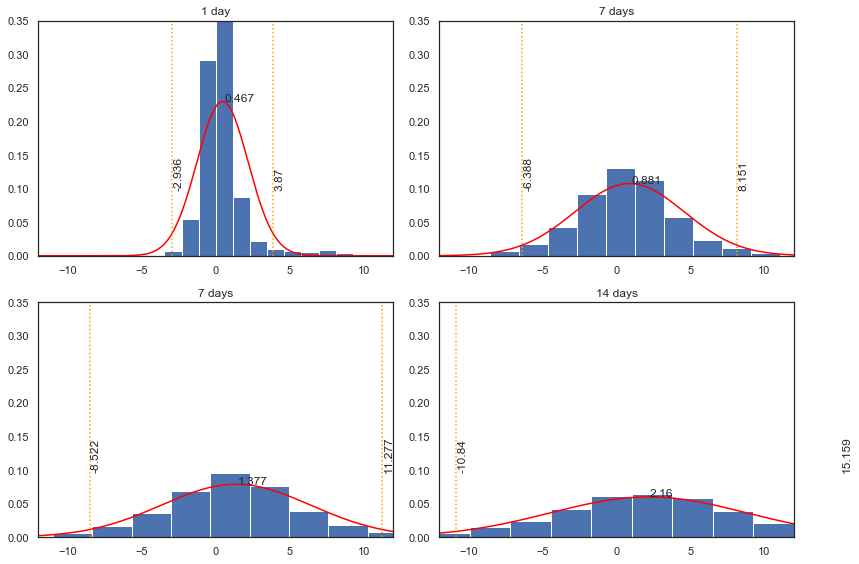

In [663]:
dds = ['1 day','7 days', '14 days', '28 days']
fig, axs = plt.subplots(2,2,figsize=(12,8))
x = np.arange(-20,20,0.1)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].hist(df_results.iloc[:,8+i*2+j],bins=20, label=dds[i*2+j],density=True)
        mean = df_results.iloc[:,8+i*2+j].mean()
        std  = df_results.iloc[:,8+i*2+j].std()
        y    = stats.norm.pdf(x,mean,std)
        axs[i,j].plot(x,y,color='red')
        axs[i,j].text(mean+0.1,y.max(),round(mean,3),)
        z1 = stats.norm(mean,std).ppf(0.025)
        z2 = stats.norm(mean,std).ppf(1-0.025)
        axs[i,j].axvline(z1, ls=':', color='orange', label=z1)
        axs[i,j].text(z1+0.1,.1,round(z1,3),rotation=90)
        axs[i,j].axvline(z2, ls=':', color='orange', label=z2)
        axs[i,j].text(z2+0.1,.1,round(z2,3),rotation=90)
        axs[i,j].set_xlim((-12,12))
        axs[i,j].set_ylim((0,0.35))
        axs[i,j].set_title(dds[i+j])
        
plt.tight_layout()


Here, returns are plotted for 3 companies. The model produces much stable outputs compared to the real returns.

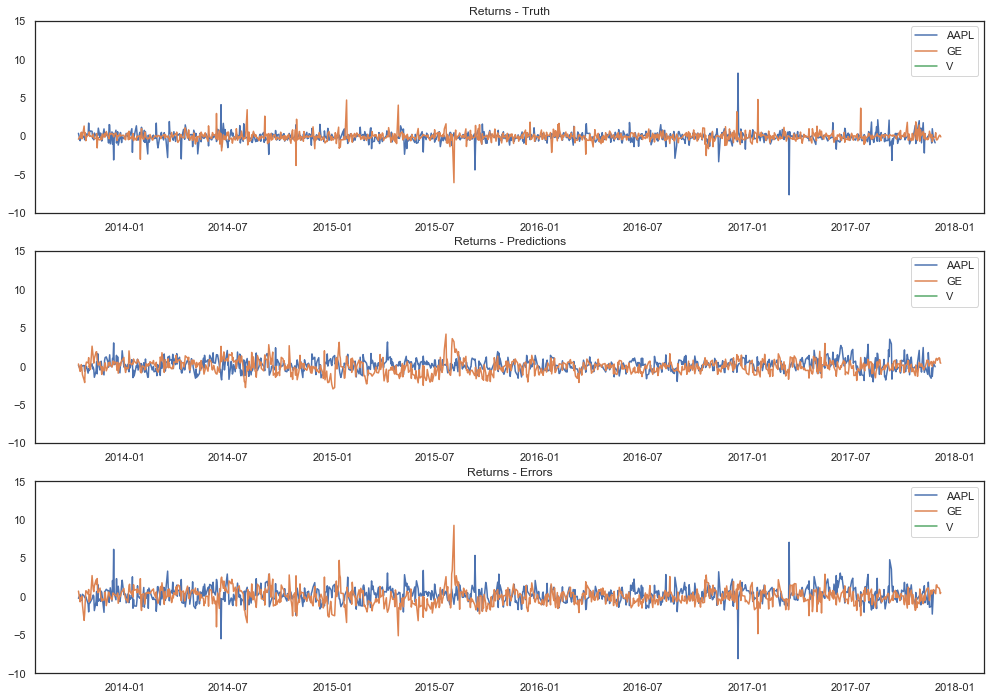

In [665]:
fig,axs = plt.subplots(3,1,figsize=(17,12))

def show_returns(to_show, shift=0):
    """Show returns for a set of companies at 1,7,14 or 28 days.
    
    Parameters
    ----------
    to_show : array-like
        contains the tickers
        
    shift : int
        0 = 1 day
        1 = 7 days
        2 = 14 days
        3 = 28 days
    """
    gs = df_results.groupby('Ticker')

    for n,g in gs:
        if n in to_show:
            x = g['Date'].values
            y1 = g.iloc[:,shift+0].values
            y2 = g.iloc[:,shift+4].values
            y3 = g.iloc[:,shift+8].values
            axs[0].plot(x,y1,label=n)
            axs[1].plot(x,y2,label=n)
            axs[2].plot(x,y3,label=n)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[0].set_ylim((-10,15))
    axs[1].set_ylim((-10,15))    
    axs[2].set_ylim((-10,15))
    axs[0].set_title('Returns - Truth')
    axs[1].set_title('Returns - Predictions')
    axs[2].set_title('Returns - Errors')
    
# df_results['Ticker'].unique()
show_returns(['GE','V','AAPL'],0)

## Conclusion

### Reflection

The end-to-end product of this project tries to bring together historical data about some of the S&P500 companies, where available through Quandl API. The data did not present inconsistencies, nor missing values, requiring only standard scaling practice before proceeding through picking a model to train and test. 

The selection fell on scikit-learn's random forest regressor. An initial overfitting happened due to lack of tuning hyper parameters, corrected by performing a grid search, and training the model through cross-validation (this was possible by creating a pipeline in order to avoid data leaks on cross validation).

Results were tested against analysing rate on returns, or RoR, and so by comparing the predicted with true returns. By doing so, it was possible to define a confidence interval relative to each time range. 7-days returns shows a 95% confidence interval of about -/+5% which was within the project's guidelines, however, by far a result to be considered good in  real-world business scenario.

Developing knowledge of time series as well as of investment principles and returns calculation was one of the most interesting aspect of the project. 

### Improvement

The nature of the problem, as well as the data here digested presents a high degree of non-linearity. Improvements to the system can be made by choosing a different model (e.g. SVM regressor to be trained on each time range) which is more prone to capture highly non-linear patterns. Eventually, going for a deep neural network might help: nlp-oriented techniques such as RNN or LSTM might be used to also include the temporality of the data (here, the window is digested as a flat vector by the model).

Then, futher feature engineering might be required. For instance, returns might be included. Moreover, company-specific indices might help in determining the volatility of the company, or their financial status such as quaterly reports data.

Finally, test of the window size might be run in order to see how this affect our model. However, to avoid increasing the dimensionality of data too much without providing a time-related approach to train our model (such in the case of a LSTM), might produce worse rather than better results.